# Modeling Hot Water Energy

### Attach current folder to project directory
### Ensure Seed for reproducability
### Set GPU configurations

In [1]:
seed_value = 123

import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [3]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

### Select the period at which we perform experiments

In [3]:
period = 6  # the period to sample the data at. 1 period= 5 minutes

### Read the cleaned data

In [4]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.090181,73.392624,85.0,12.266188,0.0,524.0,72.438095,0.004395,6.715617,107.05994,98.22113
2018-11-16 10:10:00,31.090181,72.792236,85.0,11.701546,0.0,530.0,72.438095,0.002403,6.831125,114.65901,100.06567
2018-11-16 10:15:00,31.090181,72.495117,85.0,11.578586,0.0,537.0,72.438095,0.004492,8.241195,117.93087,98.33179
2018-11-16 10:20:00,31.090181,72.495117,85.0,11.693608,0.0,543.0,72.438095,0.003086,9.518204,112.28122,95.43451
2018-11-16 10:25:00,31.090181,72.495117,85.0,11.269130,0.0,549.0,72.438095,0.006318,9.752769,109.42430,92.90832


In [5]:
# Smoothing the data
# Filter requirements.
order = 5
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

df_smoothed = dp.dfsmoothing(df=df,
                             column_names=list(df.columns),
                             order=order,
                             Wn=cutoff,
                             T=T)

Finished 'dataframeplot' in 0.0297 secs


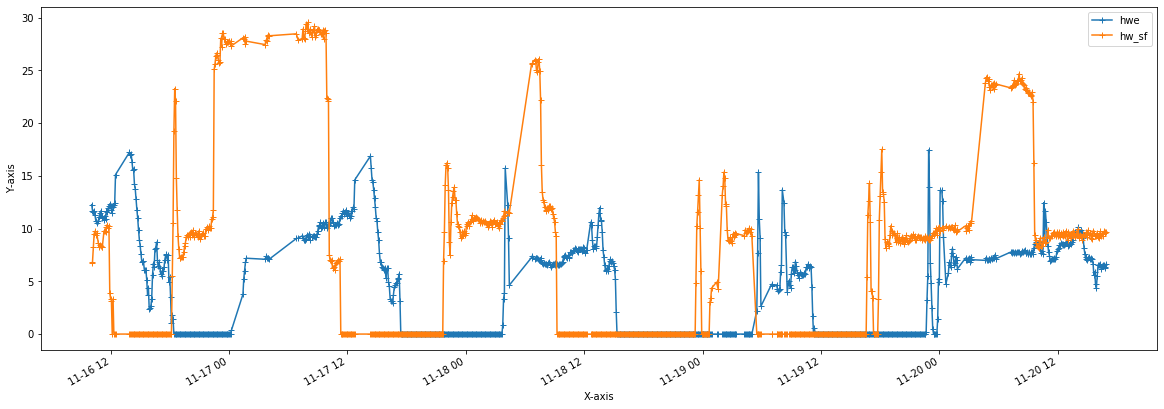

In [7]:
#%matplotlib notebook
dp.dataframeplot(df=df.loc[df.index[:1000], ['hwe','hw_sf']],
                lazy=True,
                legend=True,
                style='+-')

### Get time lagged cross correlation information

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

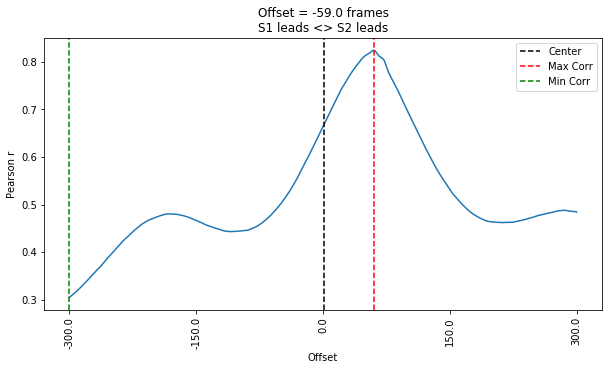

In [9]:
d1 = df['hwe']
d2 = df['hw_sf']
lags =300
fps = 1 # 1 unit = 5 mins
rs = [crosscorr(d1,d2, lag) for lag in range(-int(lags*fps),int(lags*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Max Corr')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label='Min Corr')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(np.arange(0,2*int((lags+1)*fps), lags/2))
ax.set_xticklabels(np.arange(-int(lags*fps),int((lags+1)*fps),lags/2), rotation=90);
plt.legend()

# https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

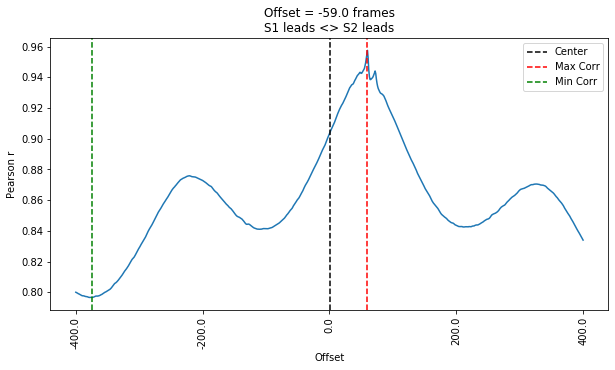

In [10]:
d1 = df['cwe']
d2 = df['flow']
lags = 400
fps = 1 # 1 unit = 5 mins
rs = [crosscorr(d1,d2, lag) for lag in range(-int(lags*fps),int(lags*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Max Corr')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label='Min Corr')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(np.arange(0,2*int((lags+1)*fps), lags/2))
ax.set_xticklabels(np.arange(-int(lags*fps),int((lags+1)*fps),lags/2), rotation=90);
plt.legend()

### Since this implies that Hot water flow leads the Hot Water Energy by approximately 59 frames or approximately 5 hours. We will use the flow as an indicator of the hybrid mode changes in the energy prediction problem. 

### Next steps:
1. Shift the hot water energy upwards/move back in time by 58 units.
2. Shift the energy by one more unit for the final prediction. 
3. For training: We break the data into batches separated by 0 energy determined by hot water flow
4. For testing:

    a. Either we do online testing where we utilize the current flow information to decide to predict or not.
    
    b. Again create batches of data based on the flow information and predict only in those batches.

In [6]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.090181,73.392624,85.0,12.266188,0.0,524.0,72.438095,0.004395,6.715617,107.05994,98.22113
2018-11-16 10:10:00,31.090181,72.792236,85.0,11.701546,0.0,530.0,72.438095,0.002403,6.831125,114.65901,100.06567
2018-11-16 10:15:00,31.090181,72.495117,85.0,11.578586,0.0,537.0,72.438095,0.004492,8.241195,117.93087,98.33179
2018-11-16 10:20:00,31.090181,72.495117,85.0,11.693608,0.0,543.0,72.438095,0.003086,9.518204,112.28122,95.43451
2018-11-16 10:25:00,31.090181,72.495117,85.0,11.269130,0.0,549.0,72.438095,0.006318,9.752769,109.42430,92.90832


In [6]:
df_out = dp.createlag(df_smoothed, ['hwe','cwe'], lag=-59)

Finished 'dataframeplot' in 0.0398 secs


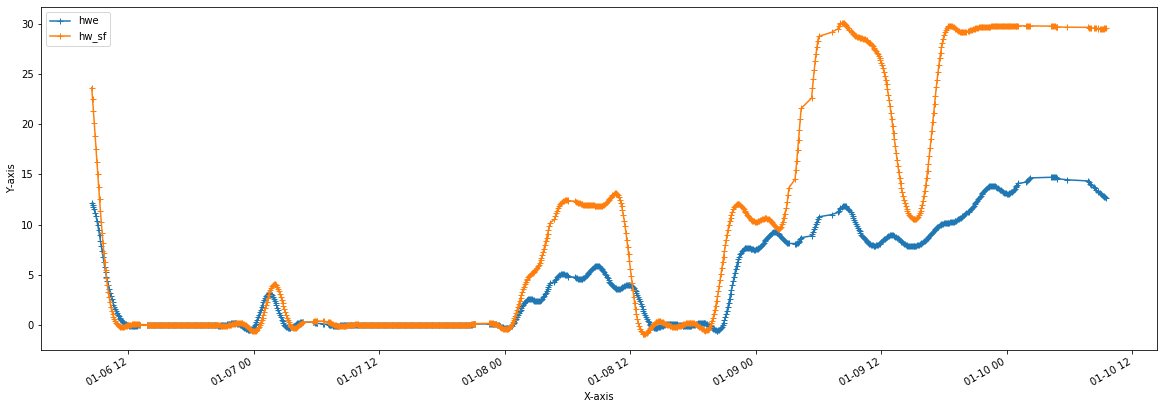

In [8]:
#%matplotlib notebook
dp.dataframeplot(df=df_out.loc[df.index[12000:13000], ['hwe','hw_sf']],
                lazy=True,
                legend=True,
                style='+-')

### Sum half hour energy data

In [7]:
# return a new column which is the sum of previous window_size values
def windowsum(df, window_size: int, column_name: str):
    return df[[column_name]].rolling(window=window_size, min_periods=window_size).sum()

df_out['30min_hwe'] = windowsum(df_out,window_size=period, column_name='hwe')
df_out = dp.dropNaNrows(df_out)

df_out.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
2018-11-16 10:30:00,31.035067,72.294783,86.121997,6.559873,-0.074854,565.999638,72.424800,-0.017122,8.773625,110.377847,96.047695,36.699631
2018-11-16 10:35:00,30.997731,72.083142,86.377001,6.669277,-0.078943,574.117299,72.424054,-0.029541,8.972761,110.919134,95.557149,37.750890
2018-11-16 10:45:00,30.961157,71.883877,86.634097,6.735677,-0.079441,581.797099,72.423763,-0.042205,9.120232,111.389786,95.068595,38.656120
2018-11-16 10:50:00,30.927595,71.699686,86.893274,6.754286,-0.076845,588.914345,72.423979,-0.054667,9.210683,111.780608,94.585195,39.370229
2018-11-16 10:55:00,30.899542,71.533133,87.154282,6.721706,-0.071726,595.343365,72.424745,-0.066429,9.239720,112.084331,94.110440,39.854369


### Sample data at half hour

In [8]:
# Sample the data at half hour intervals
df_out = dp.sample_timeseries_df(df_out, period=period)
df_out.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
2018-11-16 10:30:00,31.035067,72.294783,86.121997,6.559873,-0.074854,565.999638,72.424800,-0.017122,8.773625,110.377847,96.047695,36.699631
2018-11-16 11:00:00,30.879700,71.386590,87.416587,6.635984,-0.064696,600.959785,72.426089,-0.076961,9.204061,112.295743,93.648113,40.076803
2018-11-16 11:30:00,31.005835,71.017611,88.703866,5.441332,-0.021788,612.900220,72.441218,-0.092335,8.031554,111.933015,91.667953,36.713355
2018-11-16 12:00:00,32.003000,71.443384,89.856486,2.929877,-0.004449,582.079452,72.468720,0.017583,4.925408,109.018922,90.525998,24.126601
2018-11-16 12:30:00,34.156805,72.480124,89.755636,0.620724,-0.018241,503.409577,72.479587,0.216607,1.579319,105.337845,91.040496,9.067507


### remove 0 values from the energy

In [16]:
df_out.describe()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
count,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000,17461.000000
mean,61.346177,69.493643,56.865931,3.524106,21.032328,169.852961,71.648641,33.987889,9.413017,102.936938,92.664013,21.142169
std,16.989838,5.652470,16.462856,3.846118,17.346112,255.934165,0.948048,30.335225,9.715231,14.281361,13.907987,23.052392
min,17.562966,51.414037,17.318977,-1.316666,-3.092499,-56.201757,66.101703,-1.806047,-2.484255,80.075722,63.824775,-8.381700
25%,47.244420,67.198887,44.320312,0.043751,5.348388,-0.021009,70.942869,7.624756,0.165661,90.383204,82.271268,0.270462
50%,60.984331,71.731659,56.500982,2.332870,14.966873,10.736843,71.323809,21.405845,6.451078,97.986945,89.975170,13.952004
75%,75.257789,73.137724,69.271714,5.408236,37.663093,266.325098,72.774546,61.839263,13.373266,114.836441,100.332040,32.330008
max,97.158479,78.917628,93.536813,17.007696,77.450150,963.483816,73.561111,125.401192,32.706693,150.216620,136.016809,101.827837


In [9]:
df_out = df_out[df_out['30min_hwe']>0]
df_out = df_out[df_out['hw_sf']>0]

### Create 7 day chunks of data

In [10]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist_alt(df_out[['oat', 'orh', 'sat', 'ghi', 'hw_sf', '30min_hwe', 'hw_st']],
                      subsequence=True,
                      period=period,
                      days=7,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 61


### Custom way to create Training Data; Choose inputs, outputs, lags, train-test splits etc

In [11]:
data_weeks = 52 # Create a large initial block 6 months ~ 26 weeks of training and testing data
weeklist = []  # create list of training, testing arrays
inputcols = ['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st']  # input data
outputcols = ['30min_hwe']  # output data
lag = -1  # predict next time step energy

from pandas import concat
def quickmerge(listdf):
    return concat(listdf)

### Initial Data Block for offline training

In [12]:
datablock = dflist[:data_weeks]
datablock_df = quickmerge(datablock)
splitvalue =  (data_weeks-1)/data_weeks  # One week for training
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=lag,
        split=splitvalue,
    input_timesteps=1,
    )

idx_end = -max(X_test.shape[1],y_test.shape[1])
idx_start = idx_end - X_test.shape[0] + 1

test_idx = datablock_df.index[[i for i in range(idx_start,idx_end+1,1)]]

weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[0].year), 
                                      str(datablock_df.index[0].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })

### Create small blocks of data for weekly training

In [13]:
for weekdata in dflist[data_weeks:]:
    
    datablock = datablock[1:]+[weekdata]# remove 1st of data from initial_datablock
    splitvalue = (len(datablock)-1)/len(datablock)
    datablock_df = quickmerge(datablock)
    # and add new week data from weekdata
    
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=lag,
        split=splitvalue,
        input_timesteps=1,
    )

    idx_end = -max(X_test.shape[1],y_test.shape[1])
    idx_start = idx_end - X_test.shape[0] + 1
    test_idx = datablock_df.index[[i for i in range(idx_start,idx_end+1,1)]]

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[-1].year), 
                                      str(datablock_df.index[-1].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })

print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 10


### Print size and shape of data to feed to the LSTM for sanity checks

In [14]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            print("name: {}, value: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, value: Year-2018-Week-46
name: X_train, value: (11852, 1, 6)
name: y_train, value: (11852, 1, 1)
name: X_test, value: (233, 1, 6)
name: y_test, value: (233, 1, 1)
name: test_idx, value: (233,)
name: Id, value: Year-2019-Week-46
name: X_train, value: (11733, 1, 6)
name: y_train, value: (11733, 1, 1)
name: X_test, value: (231, 1, 6)
name: y_test, value: (231, 1, 1)
name: test_idx, value: (231,)
name: Id, value: Year-2019-Week-51
name: X_train, value: (11563, 1, 6)
name: y_train, value: (11563, 1, 1)
name: X_test, value: (227, 1, 6)
name: y_test, value: (227, 1, 1)
name: test_idx, value: (227,)
name: Id, value: Year-2019-Week-52
name: X_train, value: (11520, 1, 6)
name: y_train, value: (11520, 1, 1)
name: X_test, value: (226, 1, 6)
name: y_test, value: (226, 1, 1)
name: test_idx, value: (226,)
name: Id, value: Year-2020-Week-1
name: X_train, value: (11573, 1, 6)
name: y_train, value: (11573, 1, 1)
name: X_test, value: (227, 1, 6)
name: y_test, value: (227, 1, 1)
name: test_idx, 

### Create Folder to save models and tensorboard logs

In [15]:
path = '../results/lstm_hwe_trial6/'
!rm -rf ../results/lstm_hwe_trial6

# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

### Clear the Tensorflow graph from previous training

In [16]:
try:
    del nn_model
except NameError:
    pass

K.clear_session()

### Configure the LSTM model architecture

In [17]:
modelconfig = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 4,
    'train_epochs':5000,
    'retrain_from_layers':5

}

In [174]:
# weekdata = modelconfig['weeklist'][0]
# X_train = weekdata['X_train']
# y_train = weekdata['y_train']
# X_test = weekdata['X_test']
# y_test = weekdata['y_test']
# y_scaler = weekdata['y_scaler']

# #Instantiate learner model
# nn_model = mp.seq2seq_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()

### Start the week by week training procedure

In [18]:
modeldesigndone = False
initial_epoch = 0
freeze_model = True
reinitialize = True

for weekno, weekdata in enumerate(tqdm(modelconfig['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']
    y_scaler = weekdata['y_scaler']
    X_scaler = weekdata['X_scaler']

    if not modeldesigndone:

        try:
            del nn_model
        except NameError:
            pass

        K.clear_session()

        #Instantiate learner model
        nn_model = mp.ts_seq2seq_model(path,
                                       inputdim=X_train.shape[-1],
                                       outputdim=y_train.shape[-1],
                                       input_timesteps=X_train.shape[-2],
                                       period=period)

        # Desing model architecture
        nn_model.design_network(
            lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2 * modelconfig['lstm_no_layers']),
            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
            dropoutlist=[[], []], batchnormalizelist=[[], []])
        
        nn_model.model.load_weights('IntermediateModel.h5')

        # compile model
        nn_model.model_compile()

        # creating early stopping and learning reate changing callbacks
        # nn_model.model_callbacks()

        # modeldesigndone = True

    # train the model
    history = nn_model.train_model(X_train,
                                   y_train,
                                   X_test,
                                   y_test,
                                   epochs=modelconfig['train_epochs'],
                                   initial_epoch=initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = nn_model.evaluate_model(
        X_train,
        y_train,
        X_test,
        y_test,
        y_scaler,
        scaling=True,
        saveplot=False,
        Idx=weekdata['Id'],
        outputdim_names=['Hot Water Energy'])
    # do a detailed plot instead
    pu.detailedplot(period * 5,
                    xs = date2num(list(weekdata['test_idx'])),
                    outputdim=1,
                    output_timesteps=1,
                    input_timesteps=1,
                    pred=preds_test,
                    target=y_test,
                    X_var=X_test,
                    saveloc=path,
                    scaling=True,
                    Xscaler=X_scaler,
                    yscaler=y_scaler,
                    typeofplot='test',
                    Idx=weekdata['Id'])

    # freeze all but dense layers at the top and compile with new weights
    if freeze_model:
        for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
            layer.trainable = False
        freeze_model = False

    if reinitialize:
        for layer in nn_model.model.layers[
                -modelconfig['retrain_from_layers']:]:
            layer.kernel.initializer.run(session=K.get_session())
            layer.bias.initializer.run(session=K.get_session())

    # compile model
    nn_model.model_compile()
    
    nn_model.model.save('IntermediateModel.h5')

  0%|          | 0/10 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 11852 samples, validate on 233 samples



Epoch 1/5000
 - 7s - loss: 0.0351 - val_loss: 0.1340
Epoch 2/5000
 - 4s - loss: 0.0294 - val_loss: 0.1396
Epoch 3/5000
 - 4s - loss: 0.0296 - val_loss: 0.1450
Epoch 4/5000
 - 4s - loss: 0.0468 - val_loss: 0.1550
Epoch 5/5000
 - 4s - loss: 0.0481 - val_loss: 0.1555
Epoch 6/5000
 - 4s - loss: 0.0480 - val_loss: 0.1553
Epoch 7/5000
 - 4s - loss: 0.0476 - val_loss: 0.1549
Epoch 8/5000
 - 4s - loss: 0.0515 - val_loss: 0.1489
Epoch 9/5000
 - 4s - loss: 0.0503 - val_loss: 0.1438


 10%|█         | 1/10 [01:18<11:49, 78.81s/it]

Train on 11733 samples, validate on 231 samples
Epoch 10/5000
 - 7s - loss: 0.0355 - val_loss: 0.1478
Epoch 11/5000
 - 4s - loss: 0.0297 - val_loss: 0.1532
Epoch 12/5000
 - 4s - loss: 0.0296 - val_loss: 0.1572
Epoch 13/5000
 - 4s - loss: 0.0443 - val_loss: 0.1793
Epoch 14/5000
 - 4s - loss: 0.0455 - val_loss: 0.1794
Epoch 15/5000
 - 4s - loss: 0.0441 - val_loss: 0.1769
Epoch 16/5000
 - 4s - loss: 0.0417 - val_loss: 0.1724
Epoch 17/5000
 - 4s - loss: 0.0462 - val_loss: 0.1603
Epoch 18/5000
 - 4s - loss: 0.0441 - val_loss: 0.1510


 20%|██        | 2/10 [02:37<10:29, 78.73s/it]

Train on 11563 samples, validate on 227 samples
Epoch 19/5000
 - 7s - loss: 0.0343 - val_loss: 0.0887
Epoch 20/5000
 - 4s - loss: 0.0293 - val_loss: 0.0935
Epoch 21/5000
 - 4s - loss: 0.0289 - val_loss: 0.0955
Epoch 22/5000
 - 4s - loss: 0.0416 - val_loss: 0.1274
Epoch 23/5000
 - 4s - loss: 0.0437 - val_loss: 0.1277
Epoch 24/5000
 - 4s - loss: 0.0420 - val_loss: 0.1254
Epoch 25/5000
 - 4s - loss: 0.0395 - val_loss: 0.1209
Epoch 26/5000
 - 4s - loss: 0.0442 - val_loss: 0.1098
Epoch 27/5000
 - 4s - loss: 0.0421 - val_loss: 0.1018


 30%|███       | 3/10 [03:55<09:09, 78.57s/it]

Train on 11520 samples, validate on 226 samples
Epoch 28/5000
 - 7s - loss: 0.0353 - val_loss: 0.0209
Epoch 29/5000
 - 4s - loss: 0.0294 - val_loss: 0.0176
Epoch 30/5000
 - 4s - loss: 0.0283 - val_loss: 0.0155
Epoch 31/5000
 - 4s - loss: 0.0242 - val_loss: 0.0100
Epoch 32/5000
 - 4s - loss: 0.0146 - val_loss: 0.0124
Epoch 33/5000
 - 4s - loss: 0.0138 - val_loss: 0.0151
Epoch 34/5000
 - 4s - loss: 0.0130 - val_loss: 0.0042
Epoch 35/5000
 - 4s - loss: 0.0116 - val_loss: 0.0041
Epoch 36/5000
 - 4s - loss: 0.0115 - val_loss: 0.0041
Epoch 37/5000
 - 4s - loss: 0.0114 - val_loss: 0.0040
Epoch 38/5000
 - 4s - loss: 0.0115 - val_loss: 0.0046
Epoch 39/5000
 - 4s - loss: 0.0111 - val_loss: 0.0051
Epoch 40/5000
 - 4s - loss: 0.0111 - val_loss: 0.0053
Epoch 41/5000
 - 4s - loss: 0.0110 - val_loss: 0.0054
Epoch 42/5000
 - 4s - loss: 0.0110 - val_loss: 0.0054
Epoch 43/5000
 - 4s - loss: 0.0110 - val_loss: 0.0054
Epoch 44/5000
 - 4s - loss: 0.0110 - val_loss: 0.0054
Epoch 45/5000
 - 4s - loss: 0.0110

 40%|████      | 4/10 [05:50<08:57, 89.63s/it]

Train on 11573 samples, validate on 227 samples
Epoch 46/5000
 - 7s - loss: 0.0189 - val_loss: 0.0110
Epoch 47/5000
 - 4s - loss: 0.0127 - val_loss: 0.0091
Epoch 48/5000
 - 4s - loss: 0.0125 - val_loss: 0.0081
Epoch 49/5000
 - 4s - loss: 0.0123 - val_loss: 0.0075
Epoch 50/5000
 - 4s - loss: 0.0122 - val_loss: 0.0071
Epoch 51/5000
 - 4s - loss: 0.0121 - val_loss: 0.0068
Epoch 52/5000
 - 4s - loss: 0.0120 - val_loss: 0.0067
Epoch 53/5000
 - 4s - loss: 0.0120 - val_loss: 0.0065
Epoch 54/5000
 - 4s - loss: 0.0119 - val_loss: 0.0064
Epoch 55/5000
 - 4s - loss: 0.0119 - val_loss: 0.0064
Epoch 56/5000
 - 4s - loss: 0.0118 - val_loss: 0.0063
Epoch 57/5000
 - 4s - loss: 0.0118 - val_loss: 0.0063
Epoch 58/5000
 - 4s - loss: 0.0107 - val_loss: 0.0060
Epoch 59/5000
 - 4s - loss: 0.0106 - val_loss: 0.0058
Epoch 60/5000
 - 4s - loss: 0.0105 - val_loss: 0.0057
Epoch 61/5000
 - 4s - loss: 0.0105 - val_loss: 0.0057
Epoch 62/5000
 - 4s - loss: 0.0105 - val_loss: 0.0056
Epoch 63/5000
 - 4s - loss: 0.0105

 50%|█████     | 5/10 [08:21<08:59, 107.96s/it]

Train on 11523 samples, validate on 226 samples
Epoch 72/5000
 - 7s - loss: 0.0220 - val_loss: 0.0492
Epoch 73/5000
 - 4s - loss: 0.0123 - val_loss: 0.0469
Epoch 74/5000
 - 4s - loss: 0.0121 - val_loss: 0.0444
Epoch 75/5000
 - 4s - loss: 0.0119 - val_loss: 0.0427
Epoch 76/5000
 - 4s - loss: 0.0118 - val_loss: 0.0414
Epoch 77/5000
 - 4s - loss: 0.0117 - val_loss: 0.0404
Epoch 78/5000
 - 4s - loss: 0.0116 - val_loss: 0.0396
Epoch 79/5000
 - 4s - loss: 0.0115 - val_loss: 0.0388
Epoch 80/5000
 - 4s - loss: 0.0115 - val_loss: 0.0380
Epoch 81/5000
 - 4s - loss: 0.0114 - val_loss: 0.0373
Epoch 82/5000
 - 4s - loss: 0.0114 - val_loss: 0.0366
Epoch 83/5000
 - 4s - loss: 0.0113 - val_loss: 0.0360
Epoch 84/5000
 - 4s - loss: 0.0113 - val_loss: 0.0354
Epoch 85/5000
 - 4s - loss: 0.0112 - val_loss: 0.0348
Epoch 86/5000
 - 4s - loss: 0.0112 - val_loss: 0.0343
Epoch 87/5000
 - 4s - loss: 0.0112 - val_loss: 0.0338
Epoch 88/5000
 - 4s - loss: 0.0111 - val_loss: 0.0334
Epoch 89/5000
 - 4s - loss: 0.0111

 60%|██████    | 6/10 [12:58<10:34, 158.58s/it]

Train on 11439 samples, validate on 225 samples
Epoch 128/5000
 - 7s - loss: 0.0143 - val_loss: 0.0466
Epoch 129/5000
 - 4s - loss: 0.0131 - val_loss: 0.0384
Epoch 130/5000
 - 4s - loss: 0.0121 - val_loss: 0.0353
Epoch 131/5000
 - 4s - loss: 0.0117 - val_loss: 0.0338
Epoch 132/5000
 - 4s - loss: 0.0115 - val_loss: 0.0330
Epoch 133/5000
 - 4s - loss: 0.0114 - val_loss: 0.0325
Epoch 134/5000
 - 4s - loss: 0.0113 - val_loss: 0.0323
Epoch 135/5000
 - 4s - loss: 0.0112 - val_loss: 0.0321
Epoch 136/5000
 - 4s - loss: 0.0112 - val_loss: 0.0320
Epoch 137/5000
 - 4s - loss: 0.0111 - val_loss: 0.0320
Epoch 138/5000
 - 4s - loss: 0.0111 - val_loss: 0.0319
Epoch 139/5000
 - 4s - loss: 0.0111 - val_loss: 0.0319
Epoch 140/5000
 - 4s - loss: 0.0100 - val_loss: 0.0304
Epoch 141/5000
 - 4s - loss: 0.0100 - val_loss: 0.0300
Epoch 142/5000
 - 4s - loss: 0.0100 - val_loss: 0.0299
Epoch 143/5000
 - 4s - loss: 0.0100 - val_loss: 0.0298
Epoch 144/5000
 - 4s - loss: 0.0100 - val_loss: 0.0298
Epoch 145/5000
 -

 70%|███████   | 7/10 [15:32<07:51, 157.31s/it]

Train on 11326 samples, validate on 223 samples
Epoch 155/5000
 - 7s - loss: 0.0141 - val_loss: 0.0362
Epoch 156/5000
 - 4s - loss: 0.0114 - val_loss: 0.0338
Epoch 157/5000
 - 4s - loss: 0.0115 - val_loss: 0.0328
Epoch 158/5000
 - 4s - loss: 0.0114 - val_loss: 0.0321
Epoch 159/5000
 - 4s - loss: 0.0114 - val_loss: 0.0316
Epoch 160/5000
 - 4s - loss: 0.0114 - val_loss: 0.0312
Epoch 161/5000
 - 4s - loss: 0.0114 - val_loss: 0.0308
Epoch 162/5000
 - 4s - loss: 0.0113 - val_loss: 0.0306
Epoch 163/5000
 - 4s - loss: 0.0113 - val_loss: 0.0303
Epoch 164/5000
 - 4s - loss: 0.0113 - val_loss: 0.0302
Epoch 165/5000
 - 4s - loss: 0.0112 - val_loss: 0.0300
Epoch 166/5000
 - 4s - loss: 0.0112 - val_loss: 0.0299
Epoch 167/5000
 - 4s - loss: 0.0111 - val_loss: 0.0298
Epoch 168/5000
 - 4s - loss: 0.0111 - val_loss: 0.0297
Epoch 169/5000
 - 4s - loss: 0.0111 - val_loss: 0.0296
Epoch 170/5000
 - 4s - loss: 0.0110 - val_loss: 0.0295
Epoch 171/5000
 - 4s - loss: 0.0110 - val_loss: 0.0295
Epoch 172/5000
 -

 80%|████████  | 8/10 [18:34<05:29, 164.56s/it]

Train on 11410 samples, validate on 224 samples
Epoch 189/5000
 - 7s - loss: 0.0188 - val_loss: 0.0240
Epoch 190/5000
 - 4s - loss: 0.0119 - val_loss: 0.0219
Epoch 191/5000
 - 4s - loss: 0.0117 - val_loss: 0.0212
Epoch 192/5000
 - 4s - loss: 0.0116 - val_loss: 0.0208
Epoch 193/5000
 - 4s - loss: 0.0116 - val_loss: 0.0205
Epoch 194/5000
 - 4s - loss: 0.0115 - val_loss: 0.0202
Epoch 195/5000
 - 4s - loss: 0.0115 - val_loss: 0.0199
Epoch 196/5000
 - 4s - loss: 0.0114 - val_loss: 0.0197
Epoch 197/5000
 - 4s - loss: 0.0114 - val_loss: 0.0195
Epoch 198/5000
 - 4s - loss: 0.0113 - val_loss: 0.0193
Epoch 199/5000
 - 4s - loss: 0.0113 - val_loss: 0.0192
Epoch 200/5000
 - 4s - loss: 0.0112 - val_loss: 0.0190
Epoch 201/5000
 - 4s - loss: 0.0112 - val_loss: 0.0189
Epoch 202/5000
 - 4s - loss: 0.0112 - val_loss: 0.0189
Epoch 203/5000
 - 4s - loss: 0.0111 - val_loss: 0.0188
Epoch 204/5000
 - 4s - loss: 0.0111 - val_loss: 0.0187
Epoch 205/5000
 - 4s - loss: 0.0111 - val_loss: 0.0186
Epoch 206/5000
 -

 90%|█████████ | 9/10 [23:04<03:16, 196.15s/it]

Train on 11378 samples, validate on 224 samples
Epoch 244/5000
 - 7s - loss: 0.0316 - val_loss: 0.0438
Epoch 245/5000
 - 4s - loss: 0.0086 - val_loss: 0.0440
Epoch 246/5000
 - 4s - loss: 0.0085 - val_loss: 0.0444
Epoch 247/5000
 - 4s - loss: 0.0084 - val_loss: 0.0397
Epoch 248/5000
 - 4s - loss: 0.0077 - val_loss: 0.0383
Epoch 249/5000
 - 4s - loss: 0.0077 - val_loss: 0.0383
Epoch 250/5000
 - 4s - loss: 0.0076 - val_loss: 0.0385
Epoch 251/5000
 - 4s - loss: 0.0080 - val_loss: 0.0349
Epoch 252/5000
 - 4s - loss: 0.0078 - val_loss: 0.0327
Epoch 253/5000
 - 4s - loss: 0.0077 - val_loss: 0.0313
Epoch 254/5000
 - 4s - loss: 0.0076 - val_loss: 0.0303
Epoch 255/5000
 - 4s - loss: 0.0076 - val_loss: 0.0297
Epoch 256/5000
 - 4s - loss: 0.0075 - val_loss: 0.0292
Epoch 257/5000
 - 4s - loss: 0.0075 - val_loss: 0.0288
Epoch 258/5000
 - 4s - loss: 0.0075 - val_loss: 0.0286
Epoch 259/5000
 - 4s - loss: 0.0075 - val_loss: 0.0284
Epoch 260/5000
 - 4s - loss: 0.0075 - val_loss: 0.0283
Epoch 261/5000
 -

100%|██████████| 10/10 [26:55<00:00, 161.57s/it]


### Plot the week by week CVRMSE error

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/lstm_hwe_trial5/30min Results_File.txt


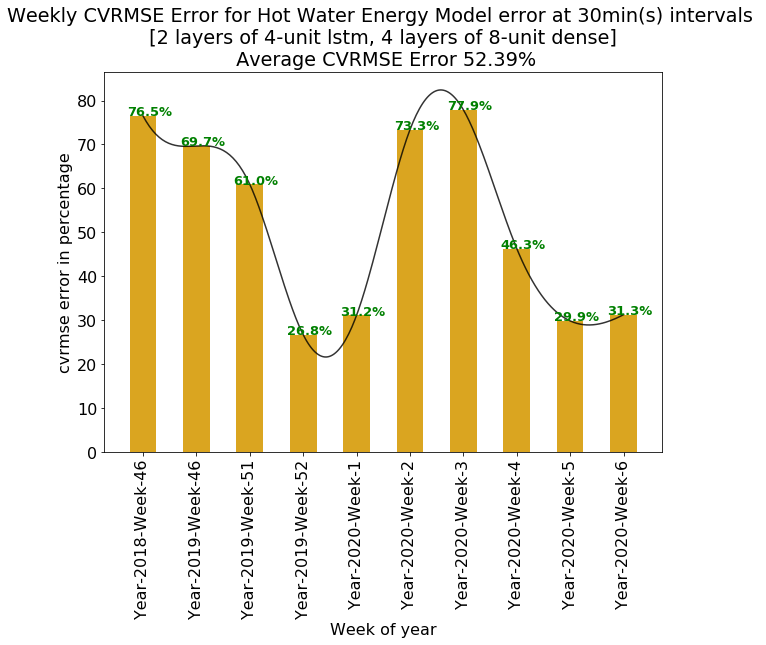

In [19]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 2 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model error at {5:}min(s) intervals \n [{0:} layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=7,
    fontsize=16)
pu.single_bar_plot(**plot_args)

### Custom method to plot all the relevant variables

### Code cemetery

In [ ]:
# from keras.utils import plot_model
# plot_model(nn_model.model, to_file='model.png',show_shapes=True,)

In [ ]:
# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)

In [ ]:
#model.model.summary()

#nn_model.model.layers[-1].input_shape

#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())

#nn_model.model.layers[-1].output_shape

In [22]:
nn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 6)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 4)              176       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 144       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 8)              40        
__________

In [ ]:
for layer in nn_model.model.layers:
     print(layer, layer.trainable, layer.name, layer.name.startswith('lstm'))

In [ ]:
nn_model.model.layers[-2].__dict__

In [ ]:
nn_model.model.layers[-9].cell.__dict__